이 데이터를 활용하여 조사 기간 동안 서울의 평균기온이 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA를 사용하여 분석하고 향후 1년 동안의 기간을 만나보고 있습니다.

의무 기간은 2023년 8월 6일 기준을 대략 1년으로 한다.

In [1]:
import sys
sys.path.append("../../")

import pyupbit
import datetime as dt
from matplotlib import pyplot as plt
from datetime import timedelta
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
from pandas import read_excel
from helper import set_datetime_index, exp_time_data

In [2]:
df = read_excel('https://data.hossam.kr/E06/temperatures_seoul.xlsx')
df

,날짜,평균기온(℃)
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9
...,...,...
18294,2023-08-02,29.7
18295,2023-08-03,29.5
18296,2023-08-04,30.0
18297,2023-08-05,30.3


In [3]:
df.columns = ['date', 'C.']
df

,date,C.
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9
...,...,...
18294,2023-08-02,29.7
18295,2023-08-03,29.5
18296,2023-08-04,30.0
18297,2023-08-05,30.3


In [4]:
df.dtypes

date    datetime64[ns]
C.             float64
dtype: object

In [5]:
df.isna().sum()

date    0
C.      0
dtype: int64

In [6]:
df3 = set_datetime_index(df, 'date')
df3.head()

,C.
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9


결측치 수: 0


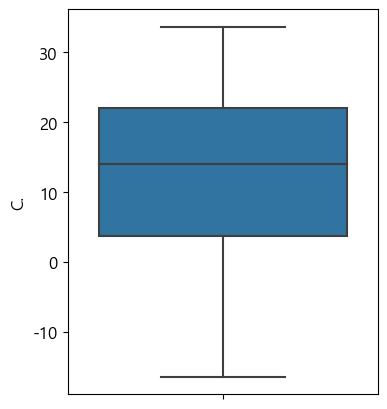

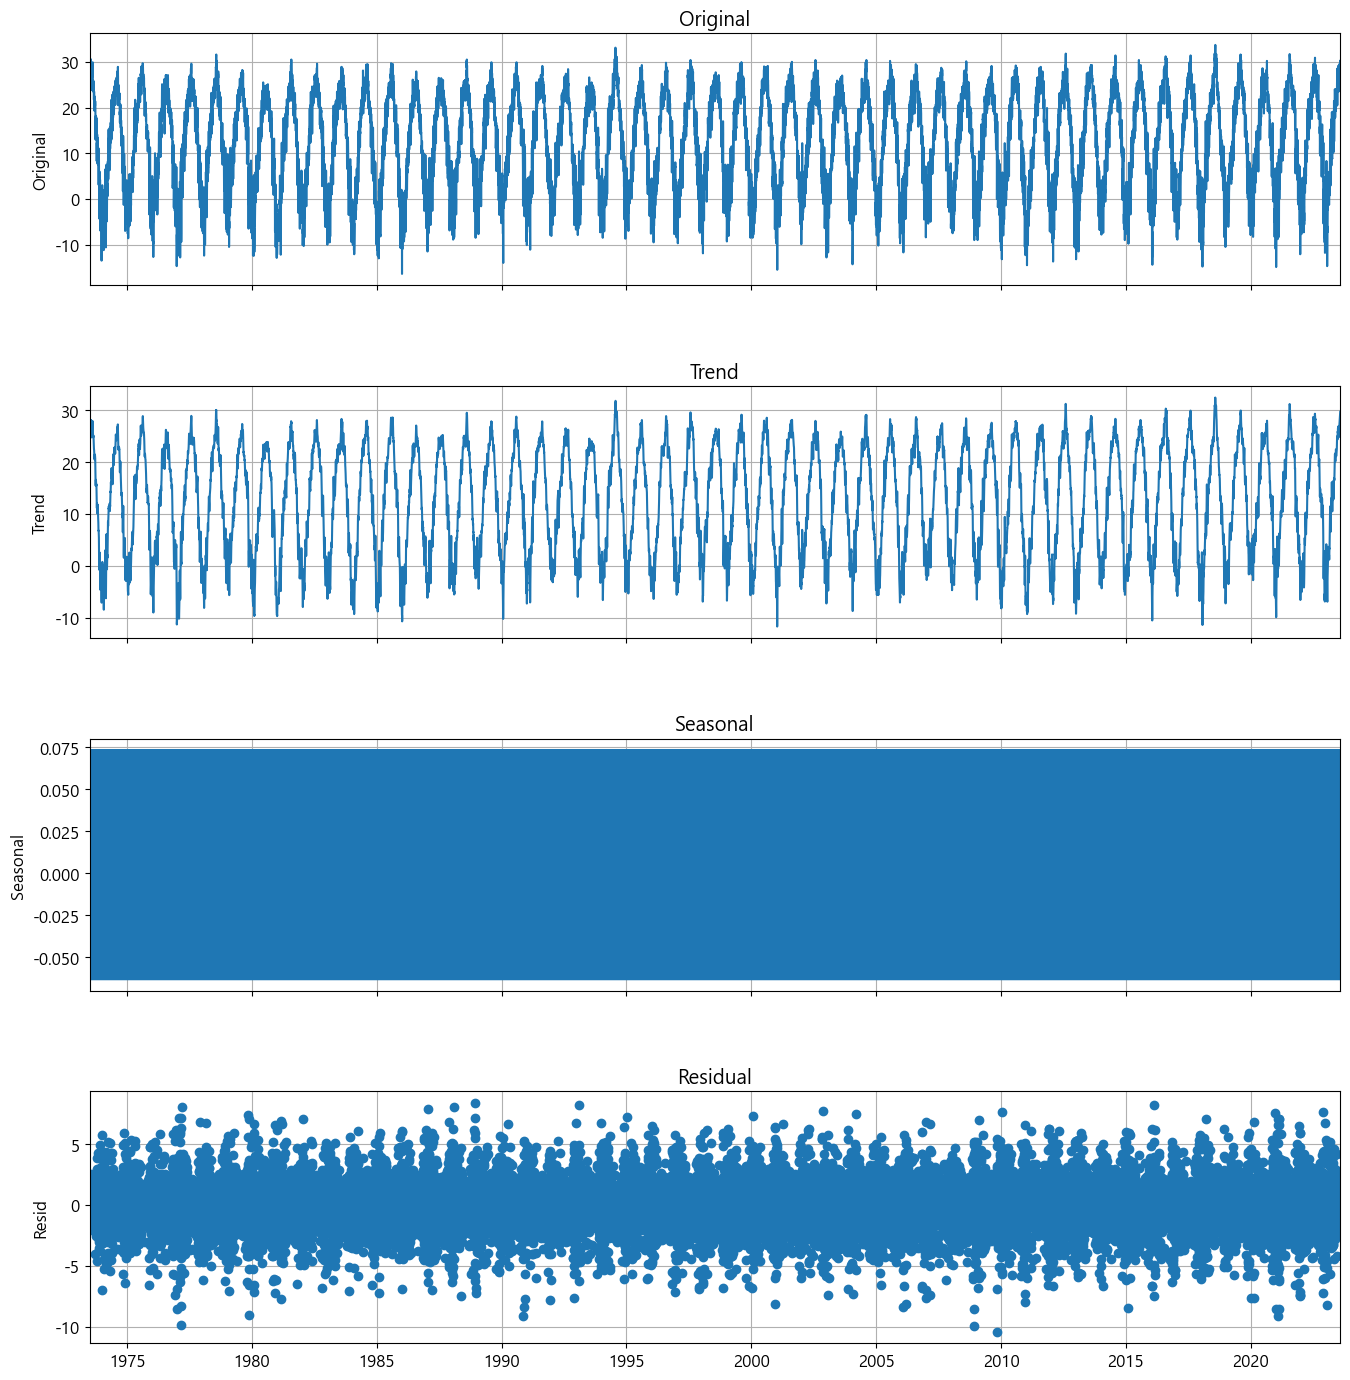

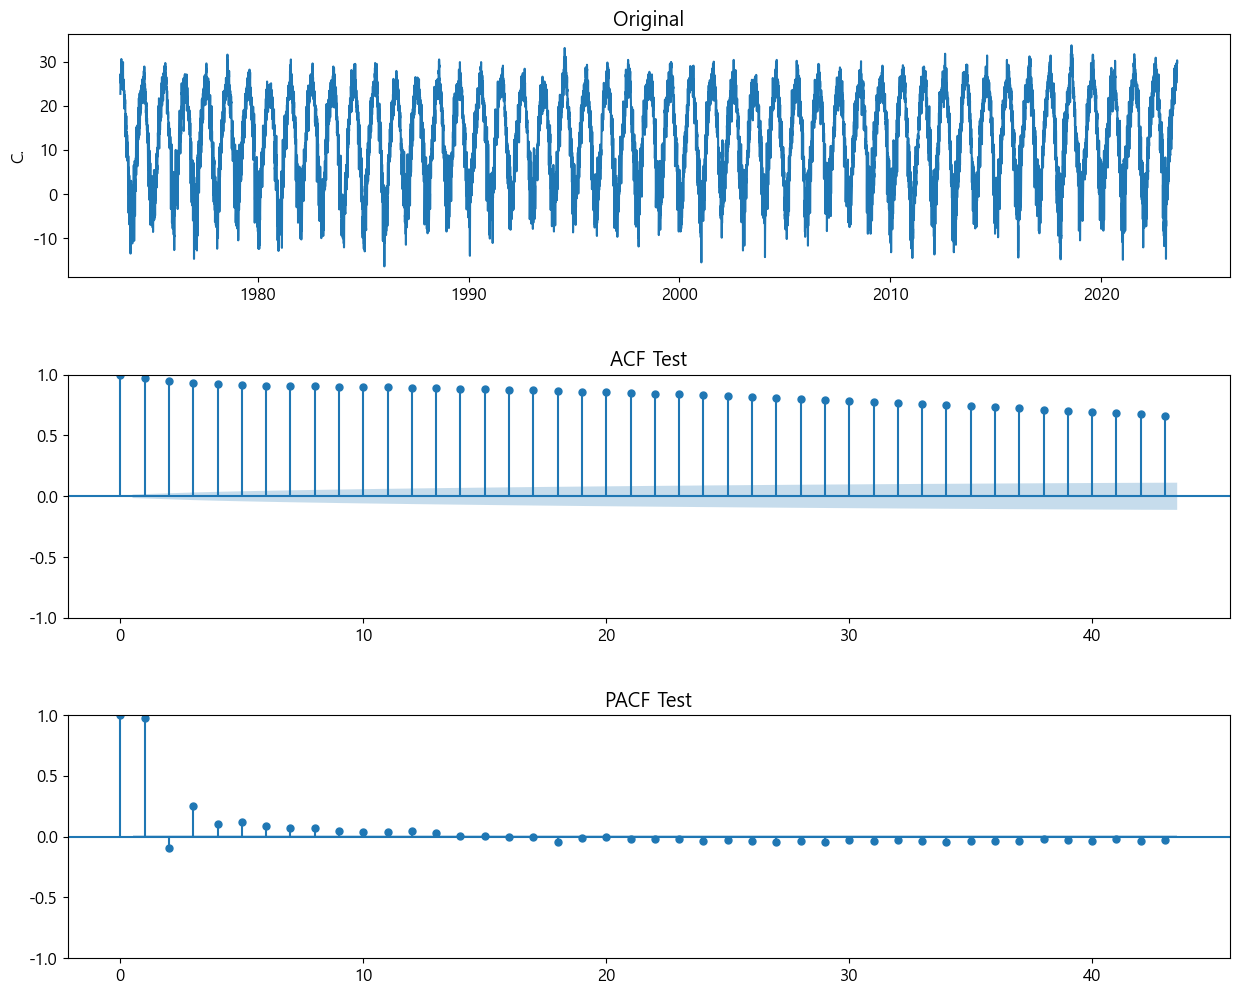

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -13.6504 |
| 유의수준(p-value)                  | 1.58975e-25 |
| 최적차수(num of lags)              |          45 |
| 관측치 개수(num of observations)   |       18253 |
| 기각값(Critical Values) 1%         |    -3.43071 |
| 기각값(Critical Values) 5%         |     -2.8617 |
| 기각값(Critical Values) 10%        |    -2.56685 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+


In [7]:
exp_time_data(data=df3, yname="C.", sd_model="a")

In [8]:
model = ARIMA(df3['C.'], order=(1,0,0), seasonal_order=(1,0,0,30))
fit = model.fit()
print(fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                               C.   No. Observations:                18299
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 30)   Log Likelihood              -41468.921
Date:                          Mon, 07 Aug 2023   AIC                          82945.843
Time:                                  14:00:18   BIC                          82977.101
Sample:                              07-01-1973   HQIC                         82956.114
                                   - 08-06-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.6486      0.799     15.834      0.000      11.083      14.214
ar.L1          0.9742      0.002    536.592      0.

In [9]:
fv = fit.fittedvalues
fv.head()

1973-07-01    12.648587
1973-07-02    22.443250
1973-07-03    23.514970
1973-07-04    26.827442
1973-07-05    24.879024
Freq: D, dtype: float64

In [19]:
fc = fit.forecast(120)
fc.head()

2023-08-07    29.351470
2023-08-08    28.916056
2023-08-09    28.514385
2023-08-10    28.083417
2023-08-11    27.709281
Freq: D, Name: predicted_mean, dtype: float64

In [24]:
last = df3.index.max()
xmin = last-timedelta(days=200)
xmax = last+timedelta(days=180+10)
ymax = df3['C.'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2023-01-18 00:00:00'), Timestamp('2024-02-12 00:00:00'), 30.3)

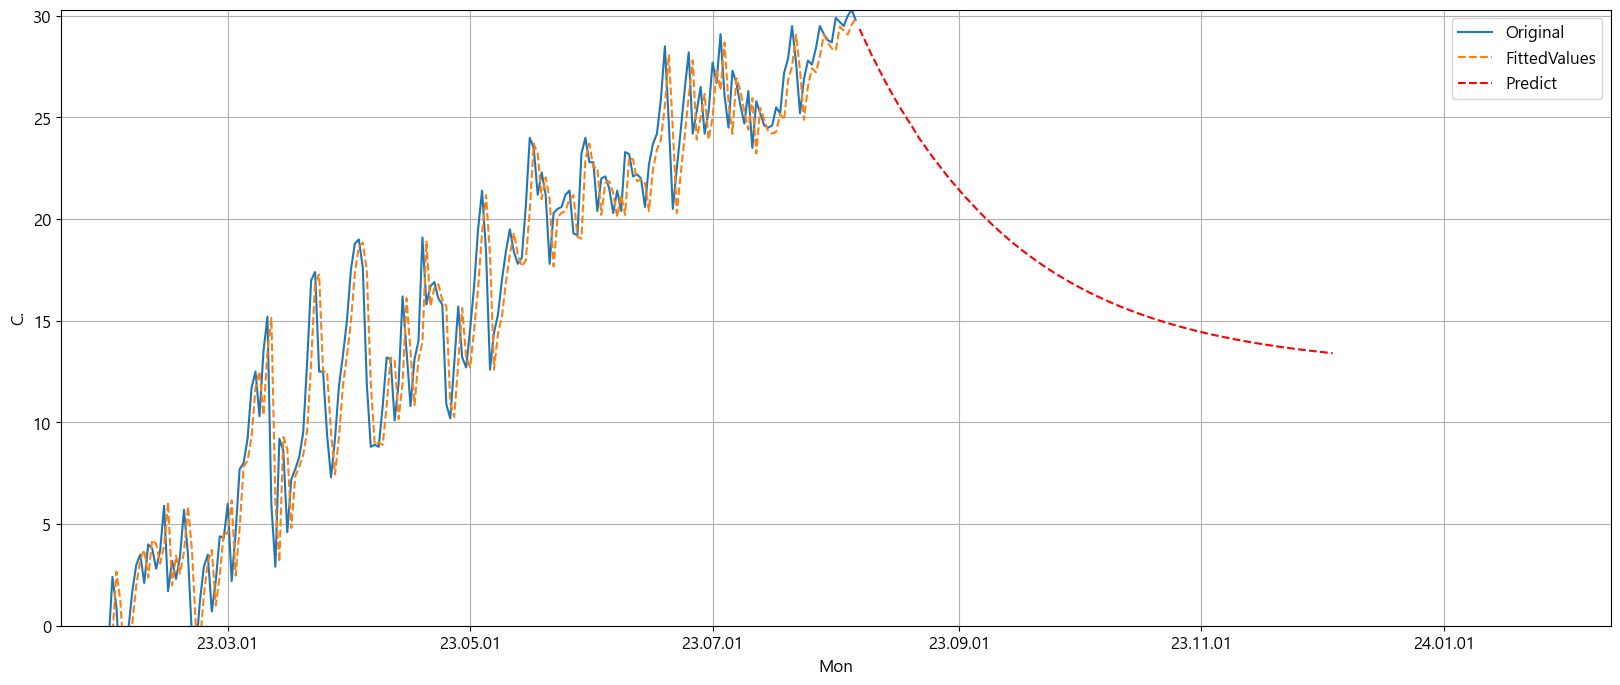

In [25]:
plt.figure(figsize=(20,8))


sb.lineplot(data=df3, x=df3.index, y='C.', label='Original')

sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')


sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Mon')
plt.ylabel('C.')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax])

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

In [13]:
my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 7    # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=df3['C.'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=137777.710, Time=0.21 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=82947.239, Time=5.73 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=154307.360, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=82945.247, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[7]             : AIC=83083.833, Time=0.19 sec

Best model:  ARIMA(1,0,0)(0,0,0)[7] intercept
Total fit time: 6.670 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18299
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -41469.624
Date:                Mon, 07 Aug 2023   AIC                          82945.247
Time:                        14:00:27   BIC                          82968.691
Sample:                    07-01-1973   HQIC                         82952.950
                         - 08-06-2023                                

In [14]:
fv = model.fittedvalues()
fv.head()

1973-07-01    12.705075
1973-07-02    22.447670
1973-07-03    23.519900
1973-07-04    26.834064
1973-07-05    24.884556
Freq: D, dtype: float64

In [15]:
fc = model.predict(n_periods=180)
fc.head()

2023-08-07    29.368425
2023-08-08    28.947746
2023-08-09    28.537687
2023-08-10    28.137981
2023-08-11    27.748365
Freq: D, dtype: float64

In [16]:
last = df3.index.max()
xmin = last-timedelta(days=180)
xmax = last+timedelta(days=180+10)
ymax = df3['C.'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2023-02-07 00:00:00'), Timestamp('2024-02-12 00:00:00'), 30.3)

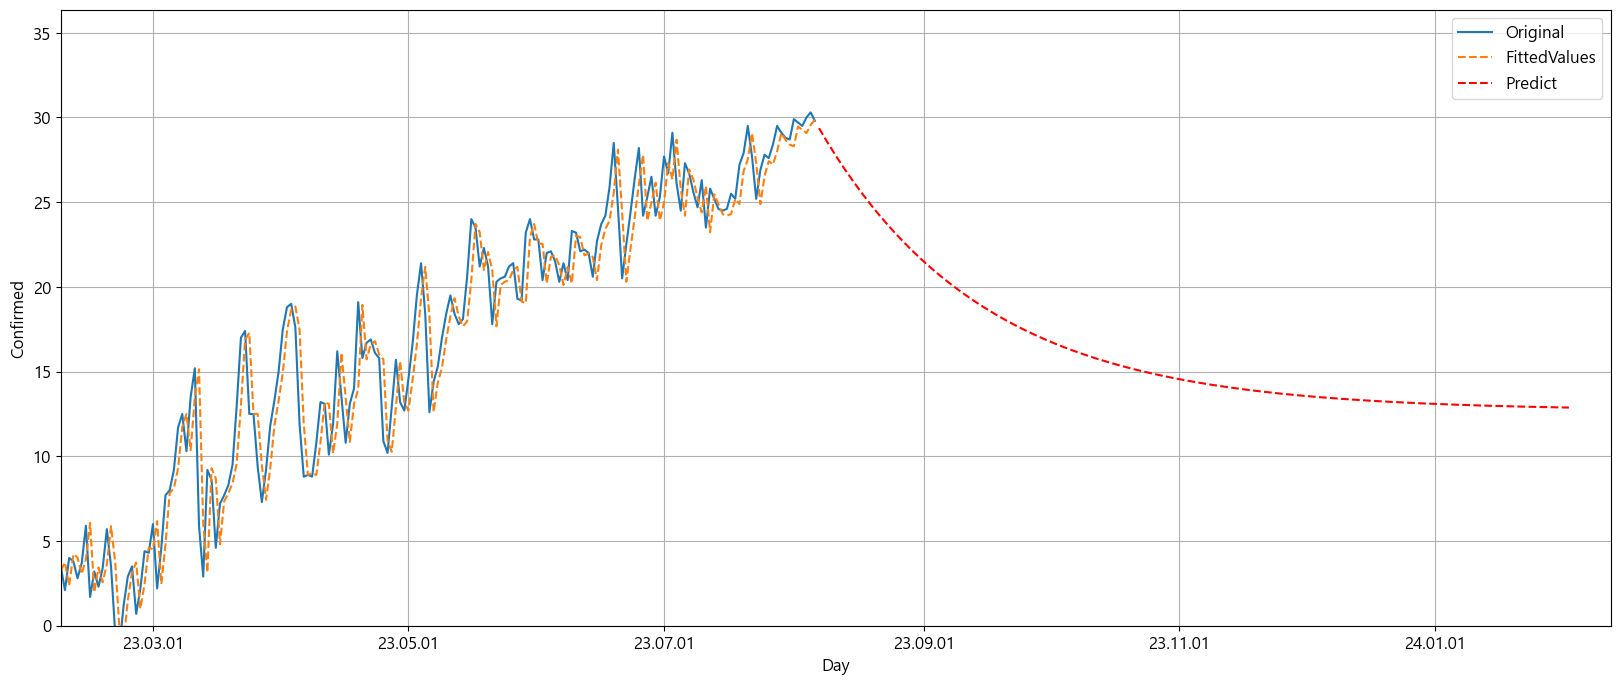

In [17]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df3, x=df3.index, y='C.', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 120일간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

문제 2

 이 데이터를 활용하여 조사 기간 동안 신생아 신생아 수가 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA중 가장 최근에 사용 가능한 방식을 선택하여 예측하고 향후 5년의 시간을 예측할 수 있는 자료를 찾게 오겠습니다.

 단, 조사하지 않은 항목에 지방이 신생아 수인 0것으로 간주한다.

In [18]:
df = read_excel('https://data.hossam.kr/E06/newborn.xlsx')
df

HTTPError: HTTP Error 404: Not Found